In [1]:
# merge_eda3 — Final EDA (stats + plots) on cleaned merged CSV

import os, ast
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from itertools import islice

CSV_IN  = "all_subreddits_merged_clean.csv"  # use the cleaned merge
OUT_DIR = "Output"                            # final outputs go here
os.makedirs(OUT_DIR, exist_ok=True)

print("Reading:", os.path.abspath(CSV_IN))
print("Saving to:", os.path.abspath(OUT_DIR))

Reading: /Users/tusharbansal/Study (UoA)/Trimester 5/Research Project A/Code/EDA Code/Merge EDA/all_subreddits_merged_clean.csv
Saving to: /Users/tusharbansal/Study (UoA)/Trimester 5/Research Project A/Code/EDA Code/Merge EDA/Output


In [2]:
df = pd.read_csv(CSV_IN)

# Prefer the cleaned tokens list if present
TOKEN_COLS = ["tokens_clean", "tokens", "clean_tokens", "tokens_list"]
token_col = next((c for c in TOKEN_COLS if c in df.columns), None)
if token_col is None:
    raise ValueError("No tokens column found. Expecting 'tokens_clean' (preferred) or similar.")

# Ensure tokens are lists[str]
def coerce_tokens(x):
    if pd.isna(x): return []
    if isinstance(x, list): return [t for t in x if isinstance(t, str)]
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        try:
            lst = ast.literal_eval(x)
            return [t for t in lst if isinstance(t, str)]
        except Exception:
            pass
    if isinstance(x, str): return x.split()
    return []

df["tokens_norm"] = df[token_col].apply(coerce_tokens)

# Basic checks
assert "subreddit" in df.columns, "Expected a 'subreddit' column."
print(df[["subreddit","tokens_norm"]].head(3))
print("Rows:", len(df))


  subreddit                                        tokens_norm
0      ADHD  [psychiatrist, decided, switch, concerta, stra...
1      ADHD  [trouble, uni, spoke, favorite, teacher, anoth...
2      ADHD  [socially, shy, growing, usually, quiet, situa...
Rows: 95250


In [3]:
counts = (df["subreddit"]
          .value_counts()
          .rename_axis("subreddit")
          .reset_index(name="posts"))

posts_csv = os.path.join(OUT_DIR, "posts_per_subreddit.csv")
counts.to_csv(posts_csv, index=False)
print("Saved:", posts_csv)
counts.head(10)

Saved: Output/posts_per_subreddit.csv


,subreddit,posts
0,SuicideBereavement,6386
1,depression,6254
2,BPD,6230
3,offmychest,6213
4,socialanxiety,6000
5,ptsd,5991
6,SuicideWatch,5880
7,mentalhealth,5825
8,alcoholism,5693
9,AnxietyDepression,5690


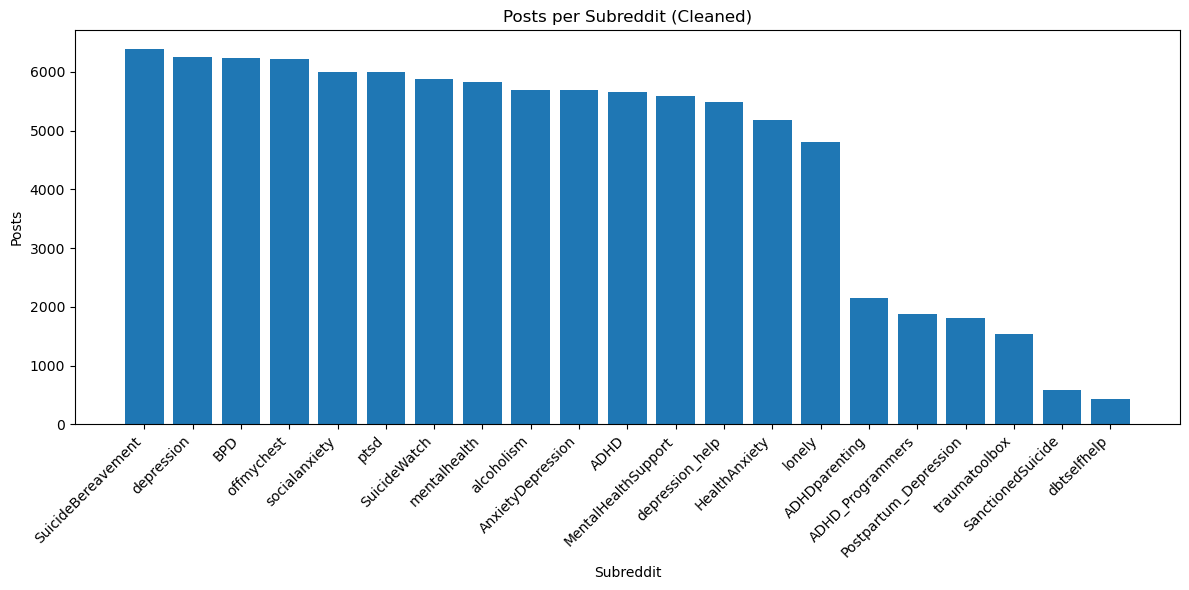

Saved: Output/posts_per_subreddit_bar.png


In [4]:
plt.figure(figsize=(12, 6))
plt.bar(counts["subreddit"], counts["posts"])
plt.xticks(rotation=45, ha="right")
plt.title("Posts per Subreddit (Cleaned)")
plt.xlabel("Subreddit")
plt.ylabel("Posts")
plt.tight_layout()

bar_png = os.path.join(OUT_DIR, "posts_per_subreddit_bar.png")
plt.savefig(bar_png, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", bar_png)

In [5]:
# per-row word count from tokens
df["word_count"] = df["tokens_norm"].map(len)

stats = (df.groupby("subreddit", as_index=False)
           .agg(posts=("subreddit","size"),
                avg_words=("word_count","mean"),
                median_words=("word_count","median")))

stats["avg_words"] = stats["avg_words"].round(2)
stats["median_words"] = stats["median_words"].round(0).astype(int)

stats_csv = os.path.join(OUT_DIR, "wordcount_stats_by_subreddit.csv")
stats.to_csv(stats_csv, index=False)
print("Saved:", stats_csv)
stats.sort_values("avg_words", ascending=False).head(10)

Saved: Output/wordcount_stats_by_subreddit.csv


,subreddit,posts,avg_words,median_words
17,offmychest,6213,86.12,60
20,traumatoolbox,1532,85.57,60
18,ptsd,5991,67.27,47
6,MentalHealthSupport,5593,66.70,46
7,Postpartum_Depression,1803,66.40,51
2,ADHDparenting,2144,63.92,49
1,ADHD_Programmers,1869,62.47,42
9,SuicideBereavement,6386,61.23,43
16,mentalhealth,5825,57.81,43
4,BPD,6230,54.81,41


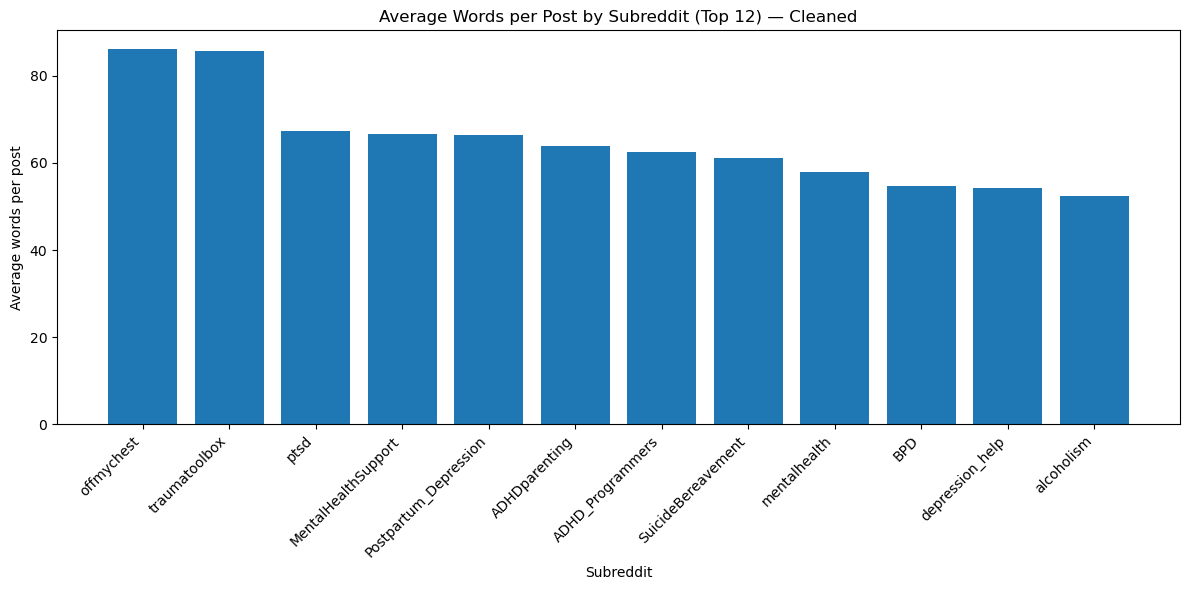

Saved: Output/avg_words_per_post_top12.png


In [6]:
top12 = stats.sort_values("avg_words", ascending=False).head(12)

plt.figure(figsize=(12, 6))
plt.bar(top12["subreddit"], top12["avg_words"])
plt.xticks(rotation=45, ha="right")
plt.title("Average Words per Post by Subreddit (Top 12) — Cleaned")
plt.xlabel("Subreddit")
plt.ylabel("Average words per post")
plt.tight_layout()

avg_png = os.path.join(OUT_DIR, "avg_words_per_post_top12.png")
plt.savefig(avg_png, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", avg_png)

In [7]:
total_posts = counts["posts"].sum()
class_tbl = counts.copy()
class_tbl["share_%"] = (class_tbl["posts"] / total_posts * 100).round(2)
class_tbl["cumulative_%"] = class_tbl["share_%"].cumsum().round(2)

imb_csv = os.path.join(OUT_DIR, "class_imbalance_table.csv")
class_tbl.to_csv(imb_csv, index=False)
print("Saved:", imb_csv)
class_tbl.head(10)

Saved: Output/class_imbalance_table.csv


,subreddit,posts,share_%,cumulative_%
0,SuicideBereavement,6386,6.70,6.70
1,depression,6254,6.57,13.27
2,BPD,6230,6.54,19.81
3,offmychest,6213,6.52,26.33
4,socialanxiety,6000,6.30,32.63
5,ptsd,5991,6.29,38.92
6,SuicideWatch,5880,6.17,45.09
7,mentalhealth,5825,6.12,51.21
8,alcoholism,5693,5.98,57.19
9,AnxietyDepression,5690,5.97,63.16


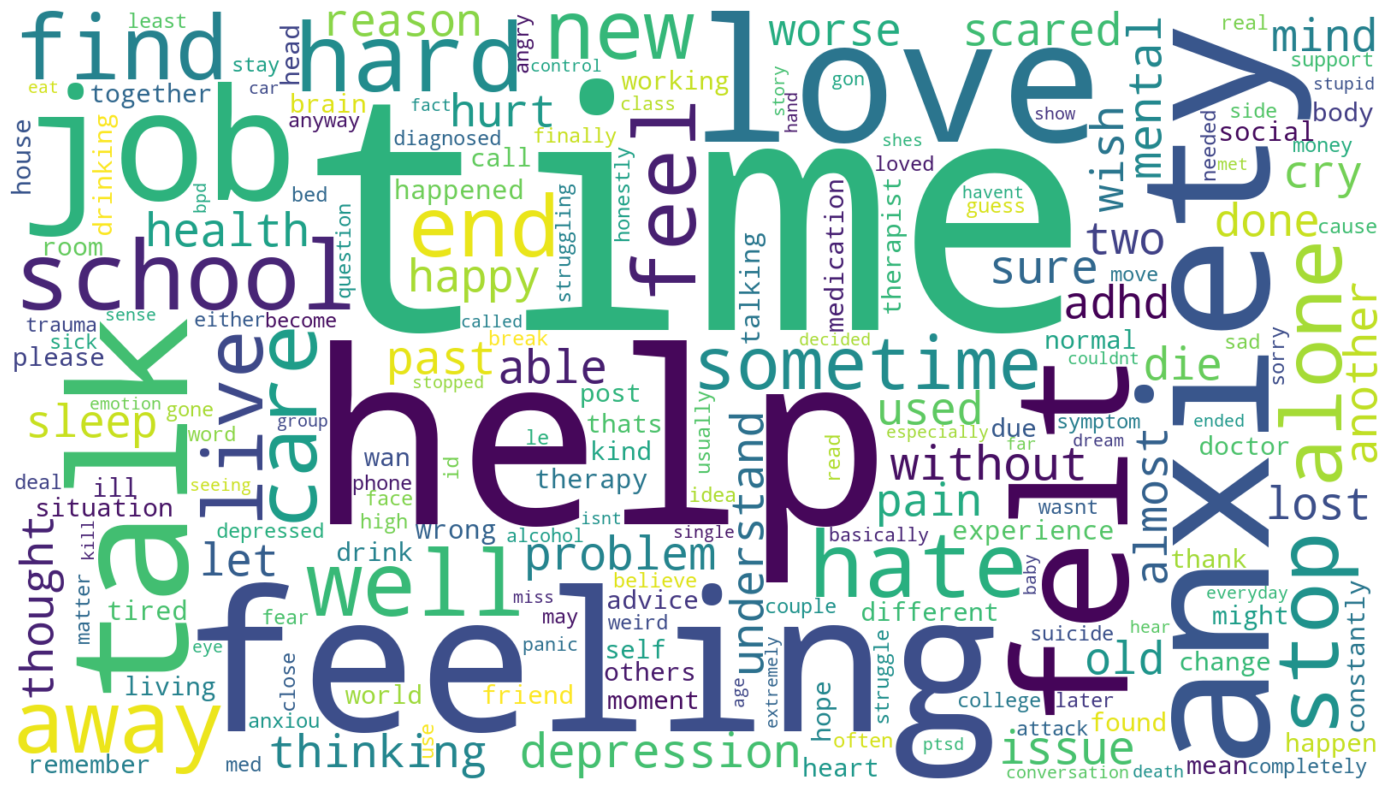

Saved: Output/merged_wordcloud_clean.png


In [9]:
# Flatten tokens for visuals
TOKENS = [t for row in df["tokens_norm"] for t in row]

extra_stop = set()  # add domain-specific junk if any appears
stopwords = set(STOPWORDS) | extra_stop

corpus = " ".join(TOKENS)
wc = WordCloud(width=1600, height=900, background_color="white",
               collocations=False, stopwords=stopwords).generate(corpus)

plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()

wc_png = os.path.join(OUT_DIR, "merged_wordcloud_clean.png")
plt.savefig(wc_png, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", wc_png)


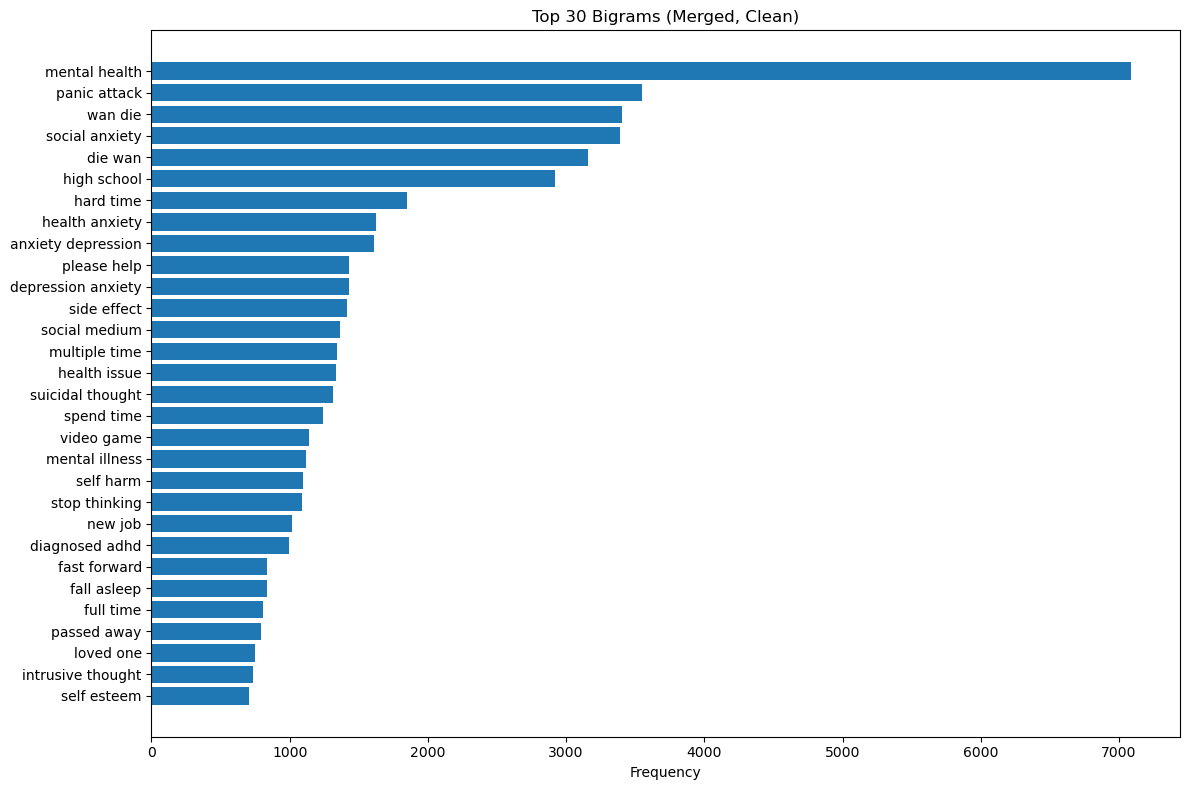

Saved: Output/merged_bigrams_top30_clean.png


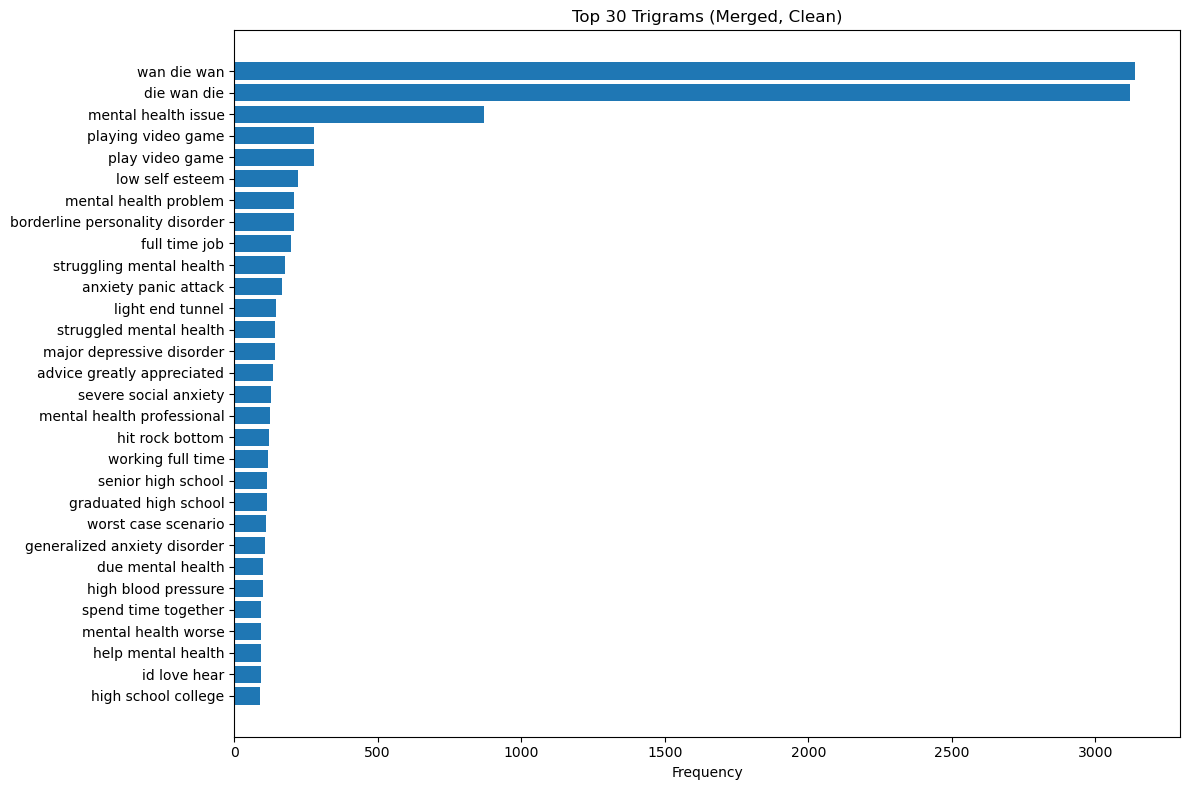

Saved: Output/merged_trigrams_top30_clean.png


In [10]:
from collections import Counter

def top_ngrams(tokens, n=2, k=30, min_len=2, max_len=30):
    toks = [t for t in tokens if min_len <= len(t) <= max_len]
    grams = zip(*(islice(toks, i, None) for i in range(n)))
    grams = [g for g in grams if not all(w == g[0] for w in g)]  # remove repeated-word grams
    return Counter(grams).most_common(k)

def plot_ngrams(top_items, title, outfile):
    labels = [" ".join(g) for g, _ in top_items]
    counts = [c for _, c in top_items]
    plt.figure(figsize=(12, 8))
    plt.barh(labels[::-1], counts[::-1])
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", outfile)

top_bi  = top_ngrams(TOKENS, n=2, k=30)
top_tri = top_ngrams(TOKENS, n=3, k=30)

bi_png  = os.path.join(OUT_DIR, "merged_bigrams_top30_clean.png")
tri_png = os.path.join(OUT_DIR, "merged_trigrams_top30_clean.png")

plot_ngrams(top_bi,  "Top 30 Bigrams (Merged, Clean)",  bi_png)
plot_ngrams(top_tri, "Top 30 Trigrams (Merged, Clean)", tri_png)